In [1]:
# 原始工作路径
%pwd

'/work/home/aojiang/06项目复现/04糖尿病视网膜病变/04Diagnosis_of_Diabetic_Retinopathy/01Diagnosis_of_Diabetic_Retinopathy_By_CNN(PyTorch)/00元代码/01初次尝试运行元代码'

In [2]:
# 修改工作路径
%cd /work/home/aojiang/00数据集/04糖尿病视网膜病变/04Diagnosis_of_Diabetic_Retinopathy

/work/home/aojiang/00数据集/04糖尿病视网膜病变/04Diagnosis_of_Diabetic_Retinopathy


In [3]:
# 查看是否修改完成
%pwd

'/work/home/aojiang/00数据集/04糖尿病视网膜病变/04Diagnosis_of_Diabetic_Retinopathy'

In [4]:
#在终端中安装包
#pip show pandas || pip install pandas -i https://pypi.tuna.tsinghua.edu.cn/simple
#pip show matplotlib || pip install matplotlib -i https://pypi.tuna.tsinghua.edu.cn/simple
#pip show seaborn || pip install seaborn -i https://pypi.tuna.tsinghua.edu.cn/simple
#pip show torch || pip install torch -i https://pypi.tuna.tsinghua.edu.cn/simple
#pip show torchvision || pip install torchvision -i https://pypi.tuna.tsinghua.edu.cn/simple
#pip show Pillow || pip install Pillow -i https://pypi.tuna.tsinghua.edu.cn/simple
#pip show tqdm || pip install tqdm -i https://pypi.tuna.tsinghua.edu.cn/simple
#pip show torchsummary || pip install torchsummary -i https://pypi.tuna.tsinghua.edu.cn/simple
#pip show scikit-learn || pip install scikit-learn -i https://pypi.tuna.tsinghua.edu.cn/simple

In [5]:
# Import essential libreries
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import copy 
import os 
import torch
from PIL import Image 
from torch.utils.data import Dataset 
import torchvision
import torchvision.transforms as transforms 
from torch.optim.lr_scheduler import ReduceLROnPlateau  
import torch.nn as nn 
from torchvision import utils 
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
from sklearn.metrics import classification_report
import itertools 
from tqdm.notebook import trange, tqdm 
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [6]:
## Data Preparation 
# Define Transformation
transform = transforms.Compose(
    [
        transforms.Resize((255,255)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [7]:
# Directory containing the subdirectories
folder_dir = r'/work/home/aojiang/00数据集/04糖尿病视网膜病变/04Diagnosis_of_Diabetic_Retinopathy'

# Convert the string path to a Path object
from pathlib import Path
folder_dir = Path(folder_dir)

In [8]:
# Define object of the Train, Validation, and Test dataset.
train_dir = folder_dir / 'train'
test_dir = folder_dir / 'test'
val_dir = folder_dir / 'valid'

train_set = torchvision.datasets.ImageFolder(train_dir, transform=transform) 
train_set.transform
test_set = torchvision.datasets.ImageFolder(test_dir, transform=transform)
test_set.transform
val_set = torchvision.datasets.ImageFolder(val_dir, transform=transform)
val_set.transform

Compose(
    Resize(size=(255, 255), interpolation=bilinear, max_size=None, antialias=None)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

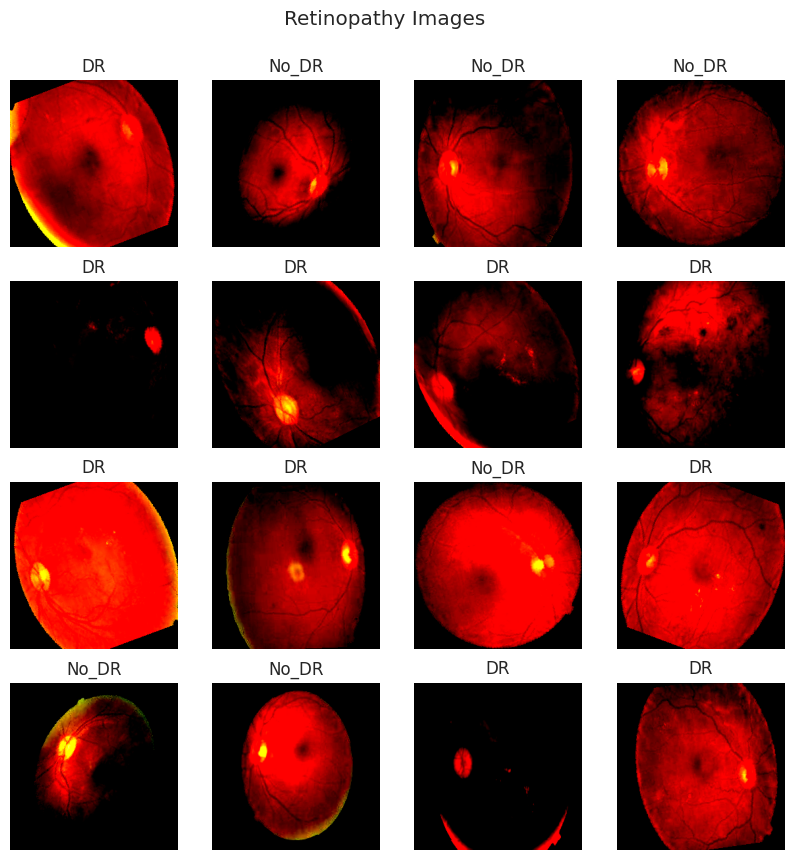

In [9]:
# Visualizing some images from Trainset
import numpy as np

CLA_label = {
        0 : 'DR',
        1 : 'No_DR',
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Retinopathy Images', y=0.95)
plt.show()

In [10]:
## Creating Dataloaders
# Import and load Train, Validation and Test set
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

In [11]:
# Print shape of Dataset
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 255, 255])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 255, 255])
Shape of y: torch.Size([64]) torch.int64



In [12]:
## Define Diabetic Retinopathy Classifier
'''This function can be useful in determining the output size of a convolutional layer,
given the input dimensions and the convolutional layer's parameters.'''

def findConv2dOutShape(hin,win,conv,pool=2):
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [13]:
# Define Architecture For Retinopathy Model
class CNN_Retino(nn.Module):
    
    def __init__(self, params):
        
        super(CNN_Retino, self).__init__()
    
        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"] 
        num_fc1 = params["num_fc1"]  
        num_classes = params["num_classes"] 
        self.dropout_rate = params["dropout_rate"] 
        
        # CNN Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [14]:
#下面这段代码运行所需时间较长
params_model={
        "shape_in": (3,255,255), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.15,
        "num_classes": 2}

# Create instantiation of Network class
Retino_model = CNN_Retino(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Retino_model = Retino_model.to(device)

In [15]:
# Model Summary for CNN_Retino
summary(Retino_model, input_size=(3, 255, 255),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 253, 253]             224
            Conv2d-2         [-1, 16, 124, 124]           1,168
            Conv2d-3           [-1, 32, 60, 60]           4,640
            Conv2d-4           [-1, 64, 28, 28]          18,496
            Linear-5                  [-1, 100]       1,254,500
            Linear-6                    [-1, 2]             202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.74
Forward/backward pass size (MB): 7.05
Params size (MB): 4.88
Estimated Total Size (MB): 12.67
----------------------------------------------------------------


In [16]:
## Loss Function Definition
loss_func = nn.NLLLoss(reduction="sum")

In [17]:
# Optimiser Definition
opt = optim.Adam(Retino_model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [18]:
## Training Model
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

In [19]:
## Training Function
def train_val(model, params, verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    # history of loss values in each epoch
    loss_history={"train": [],"val": []} 
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []} 
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict()) 
    # initialize best loss to a large value
    best_loss=float('inf') 

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.) 
    
    for epoch in tqdm(range(epochs)):
        
        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        
# Train Model Process

        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        

# Evaluate Model Process

        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history


In [20]:
#下面这段代码运行时，在20核心，30G内存，2张加速卡的情况下，迭代60次需要17分钟的运行时间
## Training Process
# Define various parameters used for training and evaluation of a cnn_model

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 60,
 "optimiser": optim.Adam(Retino_model.parameters(),lr=1e-4),
 "lr_change": ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# train and validate the model
model,loss_hist_m,metric_hist_m = train_val(Retino_model,params_train)

  0%|          | 0/60 [00:00<?, ?it/s]

<AxesSubplot:>

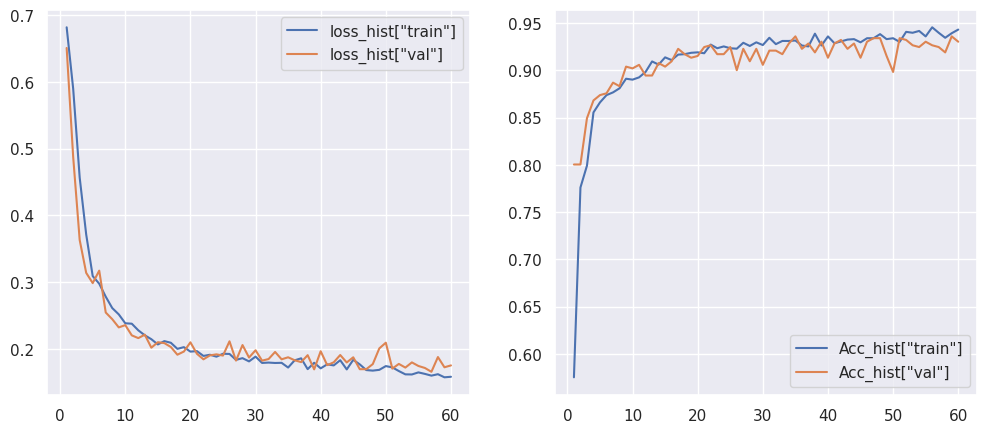

In [21]:
## Evaluation Metric Visualization
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["val"],ax=ax[1],label='Acc_hist["val"]')

In [22]:
## Classification Report
# Define Function For Classification Report
def ture_and_pred_val(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred

In [23]:
# Classification Report for Retinopathy Classification Model based on Train Set
y_true, y_pred = ture_and_pred_val(train_loader, Retino_model)
print(classification_report(y_true, y_pred), '\n\n')

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      1050
         1.0       0.94      0.96      0.95      1026

    accuracy                           0.95      2076
   macro avg       0.95      0.95      0.95      2076
weighted avg       0.95      0.95      0.95      2076
 




In [24]:
# # Classification Report for Retinopathy Classification Model based on Validation Set
y_true, y_pred = ture_and_pred_val(val_loader, Retino_model)
print(classification_report(y_true, y_pred), '\n\n')

              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       245
         1.0       0.92      0.94      0.93       286

    accuracy                           0.93       531
   macro avg       0.93      0.93      0.93       531
weighted avg       0.93      0.93      0.93       531
 




In [25]:
## Save Model
torch.save(Retino_model, "Retino_model.pt")

In [26]:
## Detection Retinopathy By Real Image
# Load the pretrained model
model = torch.load("Retino_model.pt")

# Move the model to the GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Iterate over the test loader for prediction
with torch.no_grad():
    for images, _ in test_loader:
        
        images = images.to(device)
        output = model(images)
        probabilities = torch.softmax(output, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        
        for predicted_class in predicted_classes:
            print("Predicted class:", predicted_class.item())

Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted cl

In [27]:
## Classification Report for Retinopathy Classification Model based on Test set
y_true, y_pred = ture_and_pred_val(test_loader, model)
print(classification_report(y_true, y_pred), '\n\n')

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       113
         1.0       0.93      0.96      0.95       118

    accuracy                           0.94       231
   macro avg       0.94      0.94      0.94       231
weighted avg       0.94      0.94      0.94       231
 


